Generation 10: Best Fitness = 43.4043, Mean Fitness = 89236.9984
Generation 20: Best Fitness = 22.1409, Mean Fitness = 38.6990
Generation 30: Best Fitness = 20.4426, Mean Fitness = 39.8739
Generation 40: Best Fitness = 19.9787, Mean Fitness = 44.2089
Generation 50: Best Fitness = 19.9319, Mean Fitness = 171577.0229
Generation 60: Best Fitness = 13.0538, Mean Fitness = 2974513485.3533
Generation 70: Best Fitness = 11.8657, Mean Fitness = 3294819057.5649
Generation 80: Best Fitness = 11.8457, Mean Fitness = 1413309.4845
Generation 90: Best Fitness = 11.8377, Mean Fitness = 461852.0973
Generation 100: Best Fitness = 8.0169, Mean Fitness = 327147.2638

Best Individual: if(((4.26 sub if(7.19, neg(((9.22 sub sin(sin(x))) div x)), 8.55)) div x), neg(if(neg((sin(sin(4.26)) sub if(9.22, neg(((sqrt(9.22) sub sin(4.26)) div x)), 4.26))), (exp(-3.6) sub if(4.26, if(if(neg((sin(sin(4.26)) sub if(9.22, neg(((sqrt(9.22) sub sin(4.26)) div x)), 4.26))), (exp(-3.6) sub if(4.26, if(x, sqrt(-4.96), sqrt(

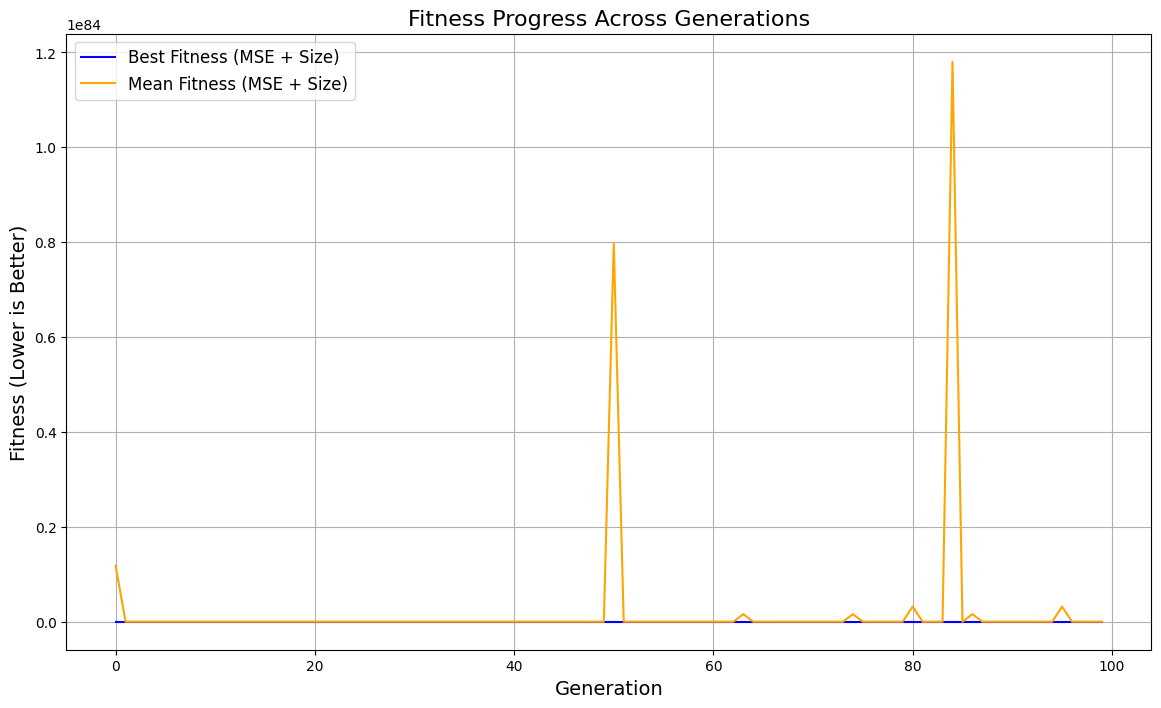

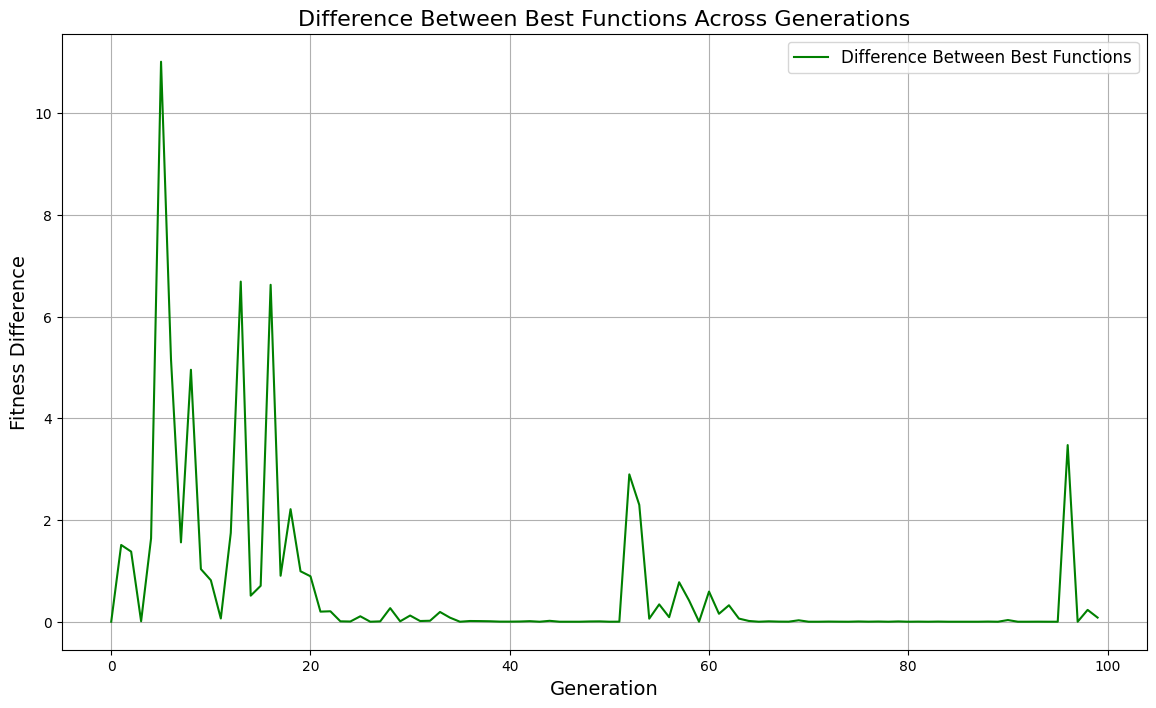

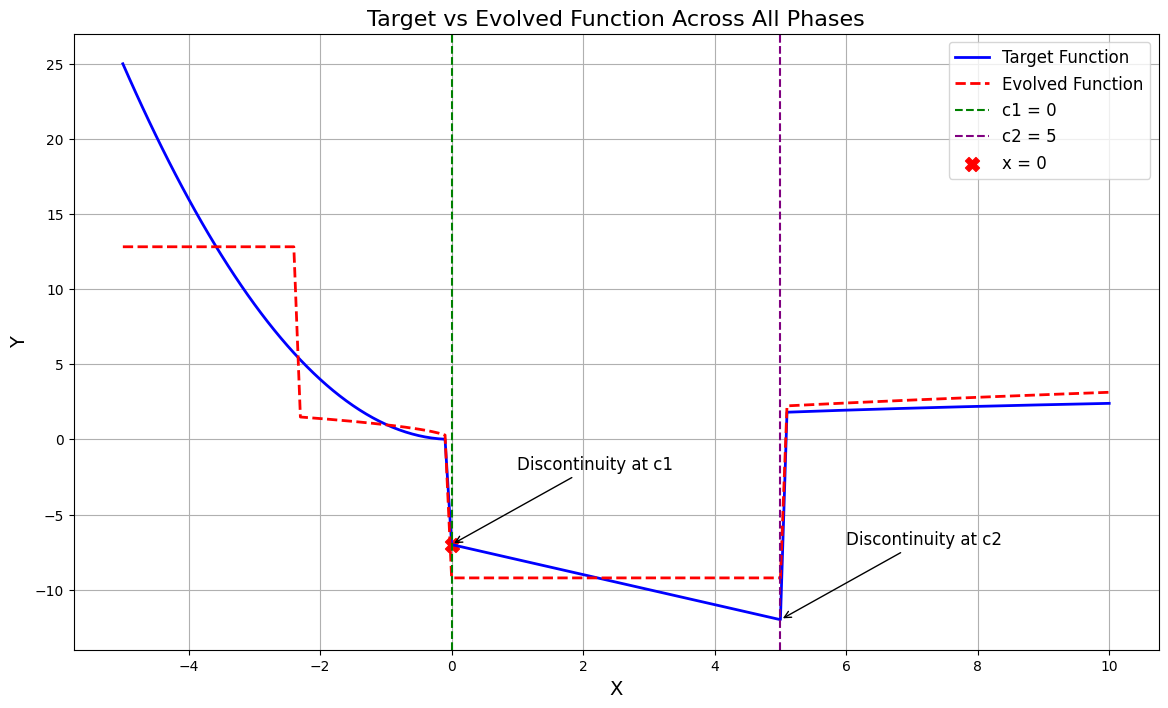

In [2]:
import math
import random
import copy
import statistics
import matplotlib.pyplot as plt

# ----------------- Configuration -----------------
POP_SIZE = 300
MAX_DEPTH = 7
GENERATIONS = 100
MUTATION_RATE = 0.3
NUM_CONSTANTS = 10
ELITE_SIZE = 5

# ----------------- Training Data (Clauses 1 & 2) -----------------
def target_function(x):
    c1, c2 = 0, 5  # Define discontinuity points
    if x < c1:
        return x**2  # Power operator
    elif c1 <= x <= c2:
        return -x - 7
    else:
        return math.log(x + 1) if x > 0 else 0  # Logarithm operator (excluded from GP)

# Expanded x range from -5.0 to10.0 with step 0.1 for higher resolution
TRAIN_X = [i / 10 for i in range(-50, 101)]  # x from -5.0 to10.0
TRAIN_Y = [target_function(x) for x in TRAIN_X]

# ----------------- Function and Terminal Sets -----------------
FUNCTION_SET = [
    {'name': 'add', 'arity': 2, 'func': lambda a, b: a + b},
    {'name': 'sub', 'arity': 2, 'func': lambda a, b: a - b},
    {'name': 'mul', 'arity': 2, 'func': lambda a, b: a * b},
    {'name': 'div', 'arity': 2, 'func': lambda a, b: a / b if b != 0 else 1.0},
    {'name': 'sin', 'arity': 1, 'func': lambda a: math.sin(a)},
    {'name': 'cos', 'arity': 1, 'func': lambda a: math.cos(a)},
    {'name': 'tan', 'arity': 1, 'func': lambda a: math.tan(a) if math.cos(a) != 0 else 1.0},
    {'name': 'sqrt', 'arity': 1, 'func': lambda a: math.sqrt(abs(a))},
    {'name': 'exp', 'arity': 1, 'func': lambda a: math.exp(a) if a < 100 else math.exp(100)},
    {'name': 'neg', 'arity': 1, 'func': lambda a: -a},
    {'name': 'if', 'arity': 3, 'func': lambda cond, a, b: a if cond > 0 else b}
]

TERMINALS = ['x'] + [round(random.uniform(-10, 10), 2) for _ in range(NUM_CONSTANTS)]

# ----------------- Node Class -----------------
class Node:
    def __init__(self, is_function, value, children=None):
        self.is_function = is_function
        self.value = value
        self.children = children if children else []

    def __str__(self):
        if self.is_function:
            if self.value['name'] == 'if':
                return f"if({self.children[0]}, {self.children[1]}, {self.children[2]})"
            elif self.value['arity'] == 1:
                return f"{self.value['name']}({self.children[0]})"
            else:
                return f"({self.children[0]} {self.value['name']} {self.children[1]})"
        else:
            return str(self.value)

# ----------------- Tree Generation -----------------
def generate_random_tree(max_depth, function_set, terminals):
    if max_depth == 0:
        return Node(is_function=False, value=random.choice(terminals))
    else:
        if random.random() < 0.7:  # Increased probability to choose function
            func = random.choice(function_set)
            children = [generate_random_tree(max_depth - 1, function_set, terminals) for _ in range(func['arity'])]
            return Node(is_function=True, value=func, children=children)
        else:
            return Node(is_function=False, value=random.choice(terminals))

# ----------------- Evaluate Expression Trees -----------------
def evaluate_tree(node, x_val):
    try:
        if node.is_function:
            func = node.value
            if func['arity'] == 1:
                return func['func'](evaluate_tree(node.children[0], x_val))
            elif func['arity'] == 2:
                return func['func'](
                    evaluate_tree(node.children[0], x_val),
                    evaluate_tree(node.children[1], x_val)
                )
            elif func['arity'] == 3:
                return func['func'](
                    evaluate_tree(node.children[0], x_val),
                    evaluate_tree(node.children[1], x_val),
                    evaluate_tree(node.children[2], x_val)
                )
        else:
            return x_val if node.value == 'x' else float(node.value)
    except (OverflowError, ZeroDivisionError, ValueError):
        return float('inf')  # Assign a high error for invalid operations

# ----------------- Fitness Function -----------------
def tree_size(node):
    if node.is_function:
        return 1 + sum(tree_size(child) for child in node.children)
    else:
        return 1

def fitness(individual, train_x, train_y, alpha=0.001):
    mse = 0
    for x, y in zip(train_x, train_y):
        pred = evaluate_tree(individual, x)
        if math.isinf(pred) or math.isnan(pred):
            return float('inf')  # Penalize invalid individuals
        mse += (pred - y) ** 2
    mse /= len(train_x)
    size = tree_size(individual)
    return mse + alpha * size  # Penalize larger trees slightly

# ----------------- Genetic Operators -----------------
def tournament_selection(population, fitnesses, k=7):
    selected = random.sample(list(zip(population, fitnesses)), k)
    return min(selected, key=lambda x: x[1])[0]

def get_all_nodes(node):
    nodes = [node]
    for child in node.children:
        nodes.extend(get_all_nodes(child))
    return nodes

def replace_subtree(original, target, replacement):
    if original is target:
        return replacement
    for i, child in enumerate(original.children):
        if child is target:
            original.children[i] = replacement
            return original
        else:
            replace_subtree(child, target, replacement)
    return original

def crossover(parent1, parent2):
    p1 = copy.deepcopy(parent1)
    p2 = copy.deepcopy(parent2)
    subtree1 = random.choice(get_all_nodes(p1))
    subtree2 = random.choice(get_all_nodes(p2))
    return replace_subtree(p1, subtree1, copy.deepcopy(subtree2))

def mutation(individual, function_set, terminals, max_depth):
    mutant = copy.deepcopy(individual)
    subtree_to_replace = random.choice(get_all_nodes(mutant))
    new_subtree = generate_random_tree(random.randint(0, max_depth//2), function_set, terminals)
    return replace_subtree(mutant, subtree_to_replace, new_subtree)

# ----------------- Main Evolutionary Loop -----------------
population = [generate_random_tree(MAX_DEPTH, FUNCTION_SET, TERMINALS) for _ in range(POP_SIZE)]
generation_best_fitness = []
generation_mean_fitness = []
generation_diff_best = []

for gen in range(GENERATIONS):
    fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
    # Sort population based on fitness (lower is better)
    sorted_population = [ind for _, ind in sorted(zip(fitnesses, population), key=lambda pair: pair[0])]
    sorted_fitnesses = sorted(fitnesses)
    
    # Elitism: Carry over the top ELITE_SIZE individuals
    elites = sorted_population[:ELITE_SIZE]
    elites_fitness = sorted_fitnesses[:ELITE_SIZE]
    
    generation_best_fitness.append(sorted_fitnesses[0])
    generation_mean_fitness.append(statistics.mean(fitnesses))
    
    # Calculate difference between best function of this generation and previous generation
    if gen > 0:
        prev_best_fitness = generation_best_fitness[gen - 1]
        generation_diff_best.append(abs(sorted_fitnesses[0] - prev_best_fitness))
    else:
        generation_diff_best.append(0)
    
    new_population = elites.copy()  # Start new population with elites
    
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(sorted_population[:POP_SIZE//2], sorted_fitnesses[:POP_SIZE//2])
        p2 = tournament_selection(sorted_population[:POP_SIZE//2], sorted_fitnesses[:POP_SIZE//2])
        child = crossover(p1, p2)
        if random.random() < MUTATION_RATE:
            child = mutation(child, FUNCTION_SET, TERMINALS, MAX_DEPTH)
        new_population.append(child)
    
    population = new_population
    
    # Optional: Print progress every 10 generations
    if (gen + 1) % 10 == 0:
        print(f"Generation {gen + 1}: Best Fitness = {sorted_fitnesses[0]:.4f}, Mean Fitness = {generation_mean_fitness[-1]:.4f}")

# ----------------- Best Solution -----------------
fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
best_idx = fitnesses.index(min(fitnesses))
best_tree = population[best_idx]
best_fitness = fitnesses[best_idx]

print(f"\nBest Individual: {best_tree}")
print(f"Best Fitness (MSE + Size Penalty): {best_fitness}")

# Calculate MSE and Accuracy Percentage
variance_of_true_outputs = statistics.pvariance(TRAIN_Y)
# Extract MSE without size penalty
mse_only = best_fitness - (0.001 * tree_size(best_tree))
accuracy_percentage = (1 - (mse_only / variance_of_true_outputs)) * 100

print(f"\nFinal Best Fitness (MSE + Size Penalty): {best_fitness:.4f}")
print(f"MSE Only: {mse_only:.4f}")
print(f"Variance of True Outputs: {variance_of_true_outputs:.4f}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")

# ----------------- Plot Results -----------------
# Plot Fitness progress
plt.figure(figsize=(14, 8))
plt.plot(range(GENERATIONS), generation_best_fitness, label="Best Fitness (MSE + Size)", color='blue')
plt.plot(range(GENERATIONS), generation_mean_fitness, label="Mean Fitness (MSE + Size)", color='orange')
plt.title("Fitness Progress Across Generations", fontsize=16)
plt.xlabel("Generation", fontsize=14)
plt.ylabel("Fitness (Lower is Better)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot Difference Between Best Functions
plt.figure(figsize=(14, 8))
plt.plot(range(GENERATIONS), generation_diff_best, label="Difference Between Best Functions", color='green')
plt.title("Difference Between Best Functions Across Generations", fontsize=16)
plt.xlabel("Generation", fontsize=14)
plt.ylabel("Fitness Difference", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Compare Target and Evolved Function in Larger Scale
plt.figure(figsize=(14, 8))

# Plot Target Function
plt.plot(TRAIN_X, TRAIN_Y, label="Target Function", color="blue", linewidth=2)

# Plot Evolved Function
estimated_y = [evaluate_tree(best_tree, x) for x in TRAIN_X]
plt.plot(TRAIN_X, estimated_y, label="Evolved Function", linestyle="--", color="red", linewidth=2)

# Highlight the phase boundaries with vertical dashed lines
c1, c2 = 0, 5
plt.axvline(x=c1, color='green', linestyle='--', label=f'c1 = {c1}')
plt.axvline(x=c2, color='purple', linestyle='--', label=f'c2 = {c2}')

# Annotate Discontinuity Points
plt.annotate('Discontinuity at c1', xy=(c1, target_function(c1)), xytext=(c1 + 1, target_function(c1) + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.annotate('Discontinuity at c2', xy=(c2, target_function(c2)), xytext=(c2 + 1, target_function(c2) + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

# Enhance Visibility at x = 0
plt.scatter(0.0, target_function(0.0), color="red", s=100, marker='X', label="x = 0")

# Plot Settings
plt.title("Target vs Evolved Function Across All Phases", fontsize=16)
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Set y-axis limits to ensure all data points are visible
plt.ylim(min(TRAIN_Y) - 2, max(TRAIN_Y) + 2)

plt.show()
